In [1]:
import tnn
import torch
import torch.nn as nn
import torch.utils.data as data
import numpy as np

from datasets import load_dataset

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

In [2]:
dataset = load_dataset("ylecun/mnist", split="test", num_proc=2)

size = 1000
test_indices = np.random.choice(len(dataset), size=size, replace=False)
test = dataset.select(test_indices)

In [3]:
def to_numpy(example):
    arr = np.reshape(example["image"], -1) / 255.0
    example["input"] = arr
    return example


test_dataset = test.map(to_numpy, num_proc=2).select_columns(["input", "label"])

Map (num_proc=2):   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
def collate_fn(batch):
    inputs = torch.tensor([ex["input"] for ex in batch]).float()
    labels = torch.tensor([ex["label"] for ex in batch]).long()
    return inputs, labels


testloader = data.DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=False,
    num_workers=2,
    collate_fn=collate_fn,
    pin_memory=True,
)

In [5]:
loss_fn = nn.CrossEntropyLoss()
model = tnn.Model(tnn.MLP())
sgdm_no_nag_landscape = tnn.Landscape.from_file(
    trainer_path="../training/mnist-momentum-no-nag.h5",
    model=model,
    loss_fn=loss_fn,
    eval_dataloader=testloader,
    device=device,
    path="../landscapes/mnist-momentum-landscape-no-nag.h5",
    verbose=25,
)

In [6]:
sgmd_no_nag_dict = sgdm_no_nag_landscape.create_meshgrid(
    resolution=10, mode="pca", endpoints=(-1, 1)
)

meshgrid creation using pca
model using cuda
meshgrid creation started
(iter: 25): iter loss: 0.1138
(iter: 50): iter loss: 0.0916
(iter: 75): iter loss: 0.0915
(iter: 100): iter loss: 0.0912
meshgrid creation complete
../landscapes
meshgrid saved to ../landscapes/mnist-momentum-landscape-no-nag.h5/landscape/meshgrid
optimizer path was saved to ../landscapes/mnist-momentum-landscape-no-nag.h5/landscape/optim_path
principle component variance was saved to ../landscapes/mnist-momentum-landscape-no-nag.h5/landscape/variance


In [7]:
model = tnn.Model(tnn.MLP())
sgdm_nag_landscape = tnn.Landscape.from_file(
    trainer_path="../training/mnist-momentum-nag.h5",
    model=model,
    loss_fn=loss_fn,
    eval_dataloader=testloader,
    device=device,
    path="../landscapes/mnist-momentum-landscape-nag.h5",
    verbose=25,
)

In [8]:
sgdm_nag_dict = sgdm_nag_landscape.create_meshgrid(
    resolution=10, endpoints=(-1, 1), mode="pca"
)

meshgrid creation using pca
model using cuda
meshgrid creation started


KeyboardInterrupt: 

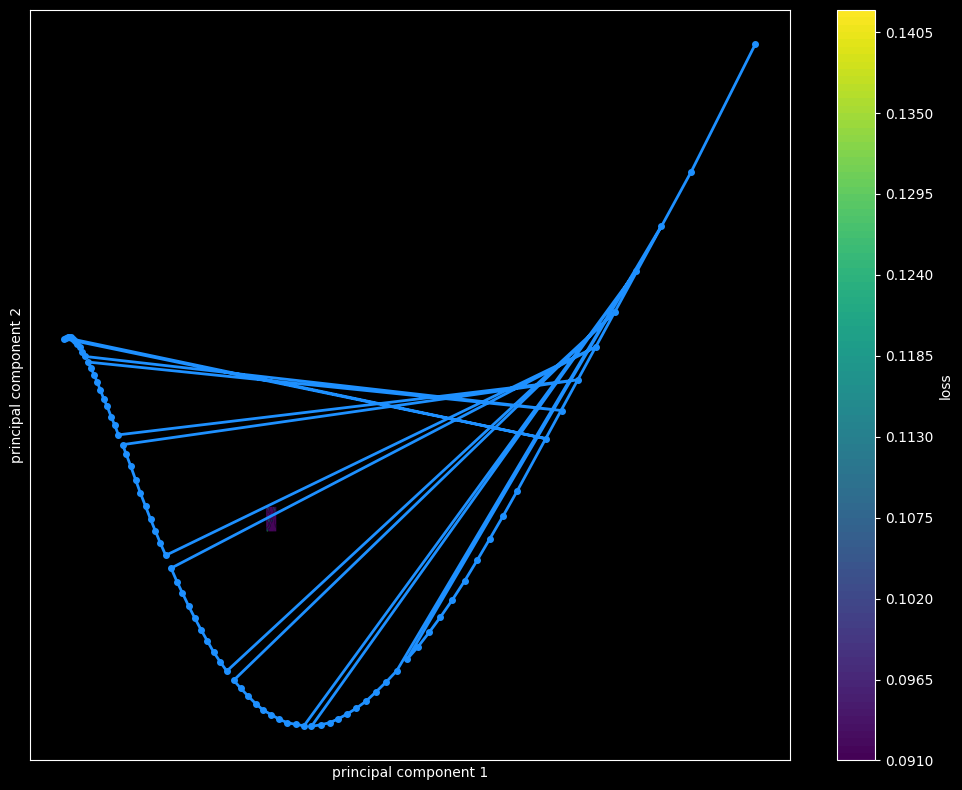

In [9]:
meshgrid = sgmd_no_nag_dict.get("meshgrid")
tnn.plot_contour(meshgrid, optim_path=sgmd_no_nag_dict.get("optim_path"))